In [3]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data - fuel_train includes fuel consumption in segments
DATA_ORIGIN = Path("data")
DATA_TRAINING = os.path.join(DATA_ORIGIN, "flights_train")
DATA_TRAINING_INTERPOLATE = os.path.join(DATA_ORIGIN,"postprocessed","training" ,"interpolated_train_mean.parquet")

DATA_SUB = os.path.join(DATA_ORIGIN, "flights_sub")
DATA_SUB_INTERPOLATE = os.path.join(DATA_ORIGIN,"postprocessed","training" ,"interpolated_sub_mean.parquet")

DATA_FINAL = os.path.join(DATA_ORIGIN, "flights_final")
TARGET_PATH = os.path.join(DATA_ORIGIN, "postprocessed", "interpolated_all_columns")

# paths
source_dir = Path(DATA_TRAINING)
target_dir = Path(TARGET_PATH)
target_dir.mkdir(parents=True, exist_ok=True)

In [4]:
# load dataframes
df_train_inter = pd.read_parquet(DATA_TRAINING_INTERPOLATE)
df_sub_inter = pd.read_parquet(DATA_SUB_INTERPOLATE)


In [18]:
# select and compare all the columns

df_train_altitude = df_train_inter.filter(items=["start","end","latitude_mean","latitude_delta", "duration_s"])
df_sub_altitude = df_sub_inter.filter(items=["start","end","latitude_mean","latitude_delta", "duration_s"])


In [26]:
import numpy as np
import matplotlib.pyplot as plt

def _to_pandas(df):
    """Accepts pandas or polars; returns pandas."""
    try:
        # polars -> pandas
        return df.to_pandas()
    except AttributeError:
        # already pandas
        return df

def _get_series(df, col):
    """Return a pandas Series from df[col], robust to polars/pandas."""
    pdf = _to_pandas(df)
    if col not in pdf.columns:
        raise KeyError(f"Column '{col}' not found. Available: {list(pdf.columns)}")
    return pdf[col]

def plot_hist_counts(train_s, sub_s, name, bins=50):
    """Counts histogram (not normalized)."""
    # shared bins built from combined data
    data = np.concatenate([train_s.dropna().values, sub_s.dropna().values])
    counts_all, edges = np.histogram(data, bins=bins)
    # re-hist with shared edges
    counts_train, _ = np.histogram(train_s.dropna().values, bins=edges)
    counts_sub, _   = np.histogram(sub_s.dropna().values, bins=edges)
    centers = 0.5 * (edges[1:] + edges[:-1])

    plt.figure(figsize=(8,5))
    plt.plot(centers, counts_train, label=f"Train (n={len(train_s)})")
    plt.plot(centers, counts_sub, label=f"Submission (n={len(sub_s)})")
    plt.fill_between(centers, counts_train, alpha=0.3)
    plt.fill_between(centers, counts_sub, alpha=0.3)
    plt.xlabel(name)
    plt.ylabel("Count")
    plt.title(f"Histogram (counts): {name}")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_hist_percent(train_s, sub_s, name, bins=50):
    """Normalized histogram as % (so datasets with different sizes are comparable)."""
    data = np.concatenate([train_s.dropna().values, sub_s.dropna().values])
    _, edges = np.histogram(data, bins=bins)

    # density=True => area=1; multiply by 100 to get %
    train_density, _ = np.histogram(train_s.dropna().values, bins=edges, density=True)
    sub_density, _   = np.histogram(sub_s.dropna().values, bins=edges, density=True)
    centers = 0.5 * (edges[1:] + edges[:-1])

    plt.figure(figsize=(8,5))
    plt.plot(centers, train_density*100, label=f"Train (n={len(train_s)})")
    plt.plot(centers, sub_density*100, label=f"Submission (n={len(sub_s)})")
    plt.fill_between(centers, train_density*100, alpha=0.3)
    plt.fill_between(centers, sub_density*100, alpha=0.3)
    plt.xlabel(name)
    plt.ylabel("Percentage of rows (%)")
    plt.title(f"Histogram (percentage): {name}")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_scatter_train_sub(train_x, train_y, sub_x, sub_y, x_label, y_label, title):
    """Scatter of mean vs delta, overlaying train and submission."""
    plt.figure(figsize=(6,6))
    plt.scatter(train_x, train_y, alpha=0.5, label="TRAIN")
    plt.scatter(sub_x,   sub_y,   alpha=0.5, label="SUBMISSION")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def compare_feature(
    df_train,
    df_sub,
    mean_col,
    delta_col,
    bins=50,
    abs_delta=False,
    title_prefix=None,
):
    """
    Make the 3 plots + print summaries for a feature pair (mean_col, delta_col).
    Works with pandas or polars DataFrames.
    """
    train_mean = _get_series(df_train, mean_col)
    train_delta = _get_series(df_train, delta_col)
    sub_mean = _get_series(df_sub, mean_col)
    sub_delta = _get_series(df_sub, delta_col)

    if abs_delta:
        train_delta = train_delta.abs()
        sub_delta   = sub_delta.abs()

    title_prefix = title_prefix or mean_col.rsplit("_", 1)[0]

    # 1) counts histograms (mean + delta)
    plot_hist_counts(train_mean, sub_mean, f"{title_prefix} :: mean", bins=bins)
    plot_hist_counts(train_delta, sub_delta, f"{title_prefix} :: delta", bins=bins)

    # 2) percentage histograms (mean + delta)
    plot_hist_percent(train_mean, sub_mean, f"{title_prefix} :: mean", bins=bins)
    plot_hist_percent(train_delta, sub_delta, f"{title_prefix} :: delta", bins=bins)

    # 3) scatter (mean vs delta)
    plot_scatter_train_sub(
        train_mean, train_delta,
        sub_mean, sub_delta,
        x_label=mean_col,
        y_label=delta_col + (" (abs)" if abs_delta else ""),
        title=f"{title_prefix}: mean vs delta (Train vs Submission)"
    )

    # 4) summaries
    def _summ(s): return (float(s.mean()), float(s.std()), int(s.notna().sum()))
    tm, ts, tn = _summ(train_mean)
    td_m, td_s, td_n = _summ(train_delta)
    sm, ss, sn = _summ(sub_mean)
    sd_m, sd_s, sd_n = _summ(sub_delta)

    print(f"\n=== {title_prefix} :: summaries ===")
    print(f"Train {mean_col}: mean={tm:.3f}, std={ts:.3f}, n={tn}")
    print(f"Train {delta_col}{' (abs)' if abs_delta else ''}: mean={td_m:.3f}, std={td_s:.3f}, n={td_n}")
    print(f"Sub   {mean_col}: mean={sm:.3f}, std={ss:.3f}, n={sn}")
    print(f"Sub   {delta_col}{' (abs)' if abs_delta else ''}: mean={sd_m:.3f}, std={sd_s:.3f}, n={sd_n}")

def compare_many(df_train, df_sub, feature_basenames, bins=50, abs_delta=False):
    """
    Convenience wrapper: pass e.g. ['latitude','longitude','altitude'] and it will
    look for '<name>_mean' and '<name>_delta' for each.
    """
    for base in feature_basenames:
        mean_col = f"{base}_mean"
        delta_col = f"{base}_delta"
        print(f"\n##### {base.upper()} #####")
        compare_feature(df_train, df_sub, mean_col, delta_col, bins=bins, abs_delta=abs_delta, title_prefix=base)



##### LATITUDE #####


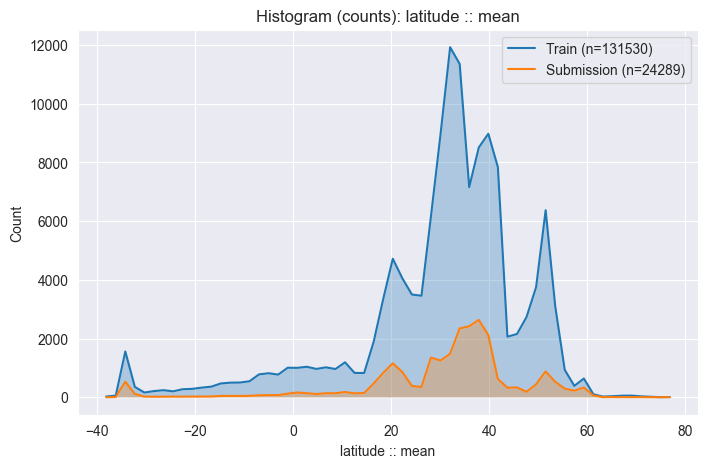

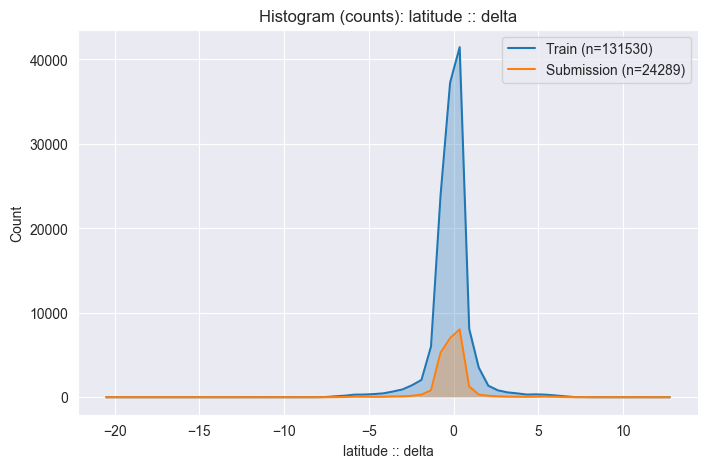

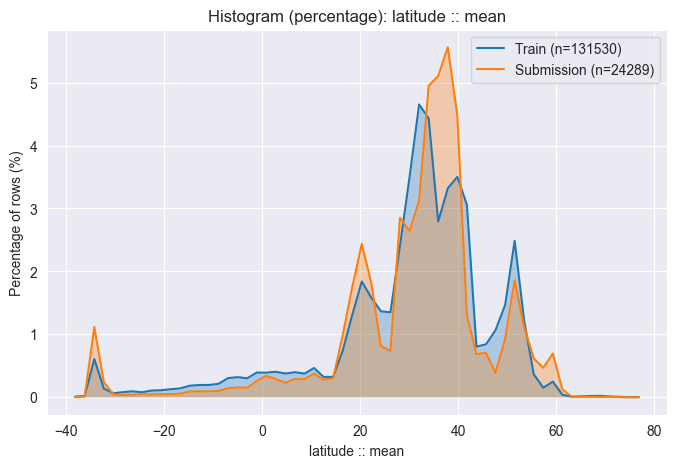

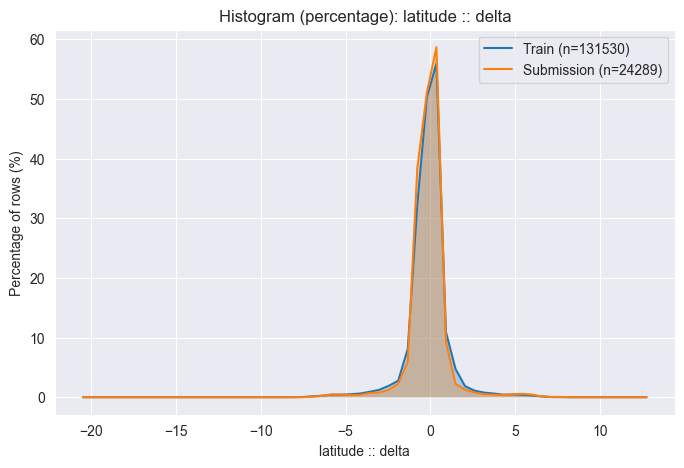

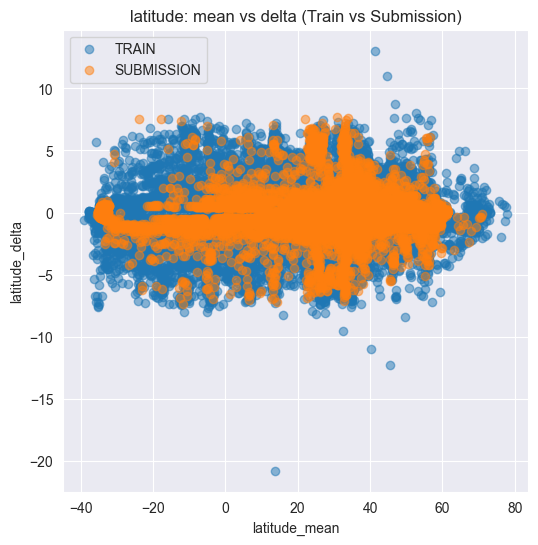


=== latitude :: summaries ===
Train latitude_mean: mean=30.205, std=17.373, n=131530
Train latitude_delta: mean=-0.074, std=1.192, n=131530
Sub   latitude_mean: mean=30.844, std=17.128, n=24289
Sub   latitude_delta: mean=-0.058, std=1.120, n=24289

##### LONGITUDE #####


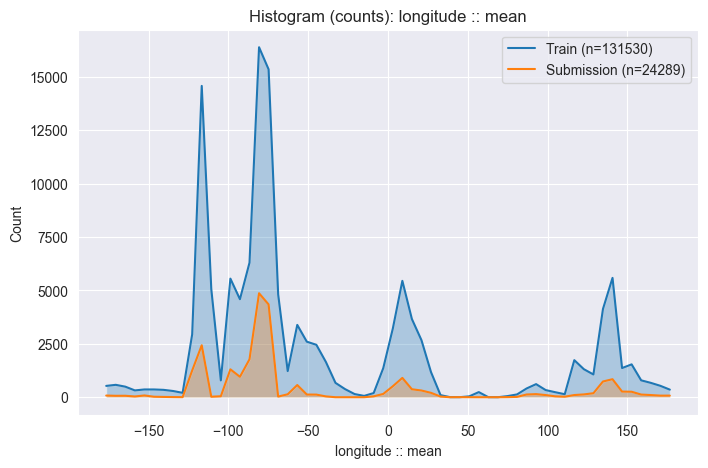

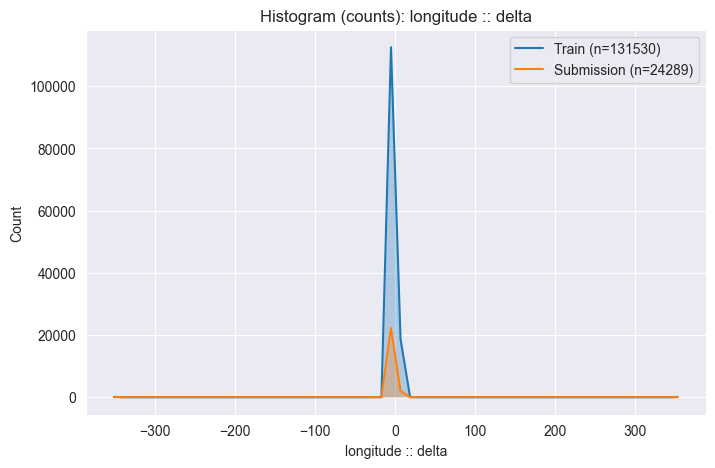

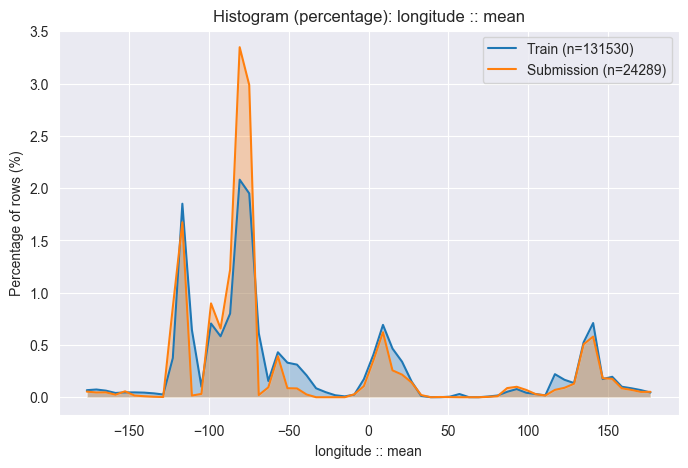

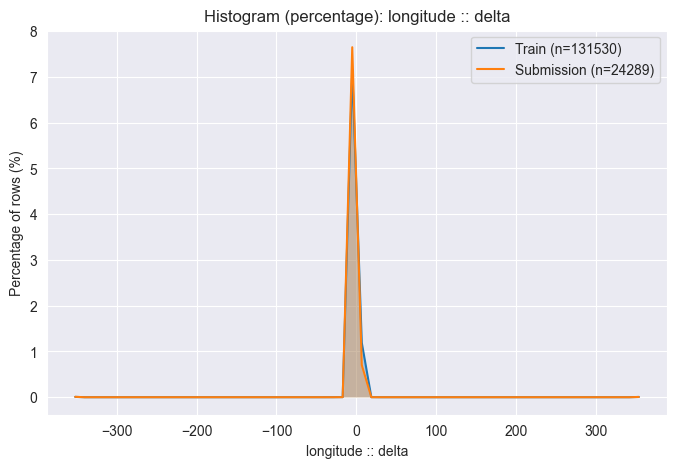

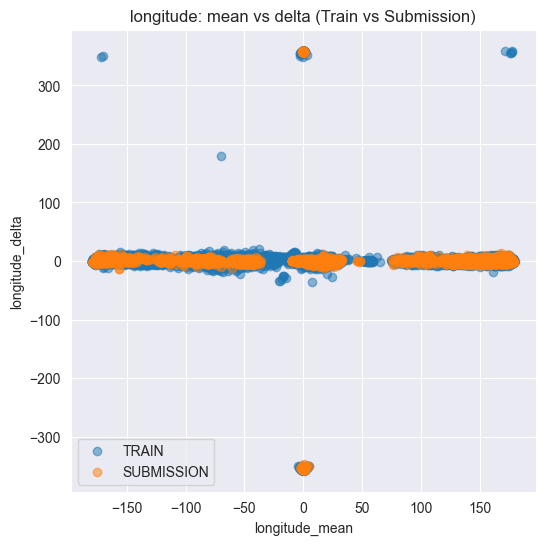


=== longitude :: summaries ===
Train longitude_mean: mean=-39.104, std=86.712, n=131530
Train longitude_delta: mean=-0.069, std=14.074, n=131530
Sub   longitude_mean: mean=-48.310, std=81.985, n=24289
Sub   longitude_delta: mean=-0.155, std=14.659, n=24289

##### ALTITUDE #####


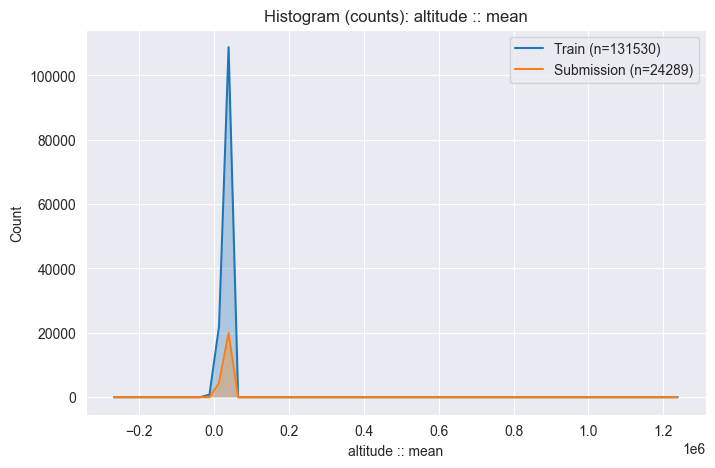

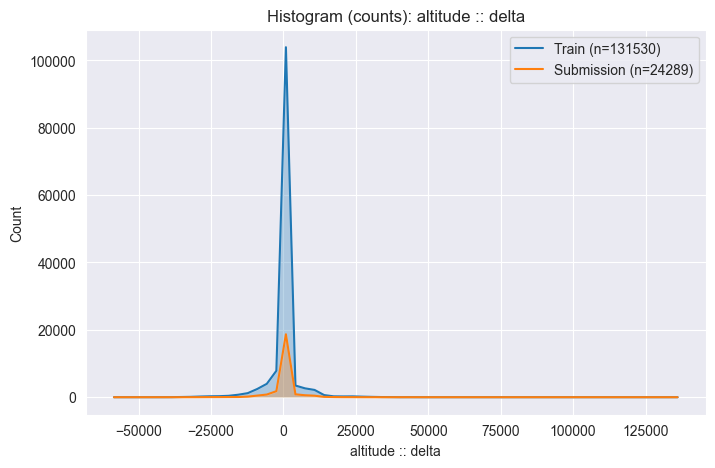

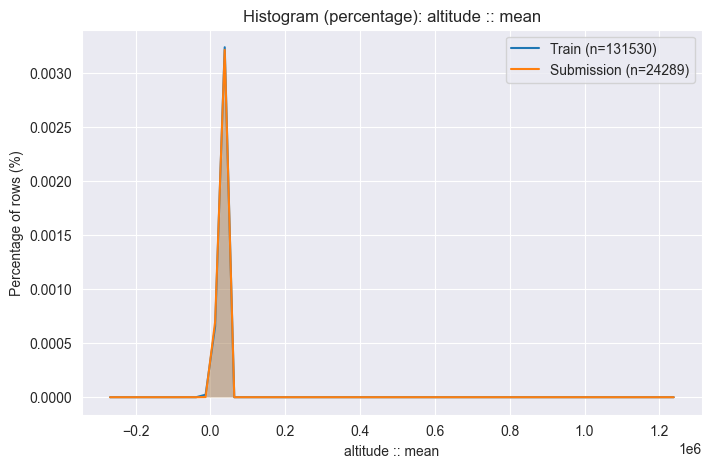

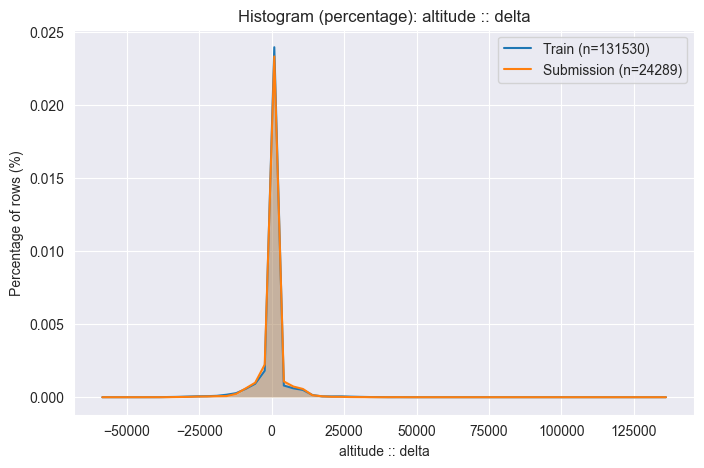

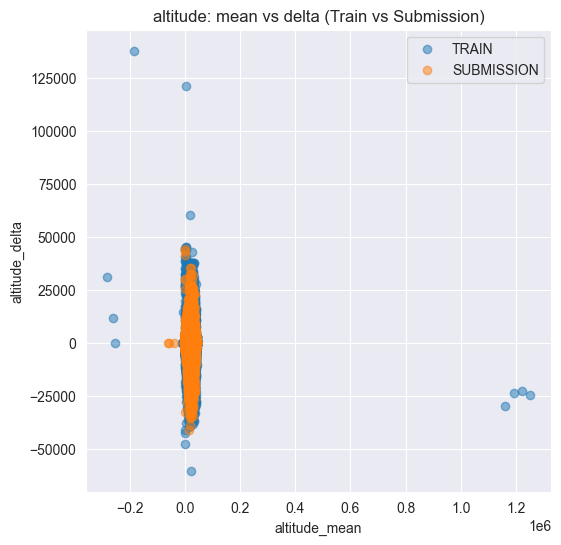


=== altitude :: summaries ===
Train altitude_mean: mean=32030.018, std=12657.929, n=131530
Train altitude_delta: mean=-157.094, std=4674.270, n=131530
Sub   altitude_mean: mean=31721.068, std=10390.849, n=24289
Sub   altitude_delta: mean=-59.292, std=4037.362, n=24289


In [29]:
# select and compare all the columns -- longitude
df_train_altitude = df_train_inter.filter(items=["start","end","longitude_mean","longitude_delta", "duration_s"])
df_sub_altitude = df_sub_inter.filter(items=["start","end","longitude_mean","longitude_delta", "duration_s"])

# 1) single feature, e.g. latitude
# compare_feature(df_train_inter, df_sub_inter, "latitude_mean", "latitude_delta", bins=60, abs_delta=False)

# 2) multiple features
compare_many(df_train_inter, df_sub_inter, ["latitude","longitude","altitude"], bins=60, abs_delta=False)

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------- helpers --------------------

def _to_pandas(df):
    """Accepts pandas or polars; returns pandas."""
    try:
        return df.to_pandas()  # polars -> pandas
    except AttributeError:
        return df              # already pandas

def _get_series(df, col):
    """Return a pandas Series from df[col], robust to polars/pandas, with a clear error if missing."""
    pdf = _to_pandas(df)
    if col not in pdf.columns:
        raise KeyError(f"Column '{col}' not found. Available: {list(pdf.columns)}")
    return pdf[col]

def _describe(series, label):
    s = series.dropna()
    mean = float(s.mean()) if len(s) else float("nan")
    std  = float(s.std())  if len(s) else float("nan")
    n    = int(s.shape[0])
    print(f"{label}: mean={mean:.3f}, std={std:.3f}, n={n}")

# -------------------- plotting primitives (one plot per call) --------------------

def plot_hist_counts(train_s, sub_s, name, bins=50):
    """Counts histogram with shared bin edges."""
    t = train_s.dropna().values
    s = sub_s.dropna().values
    data = np.concatenate([t, s]) if len(t) and len(s) else (t if len(t) else s)
    counts_all, edges = np.histogram(data, bins=bins) if len(data) else (np.array([]), np.linspace(0,1,bins+1))
    counts_train, _ = np.histogram(t, bins=edges) if len(t) else (np.zeros_like(counts_all), edges)
    counts_sub, _   = np.histogram(s, bins=edges) if len(s) else (np.zeros_like(counts_all), edges)
    centers = 0.5 * (edges[1:] + edges[:-1])

    plt.figure(figsize=(8,5))
    if len(centers):
        plt.plot(centers, counts_train, label=f"Train (n={len(train_s)})")
        plt.plot(centers, counts_sub,   label=f"Submission (n={len(sub_s)})")
        plt.fill_between(centers, counts_train, alpha=0.3)
        plt.fill_between(centers, counts_sub,   alpha=0.3)
    plt.xlabel(name)
    plt.ylabel("Count")
    plt.title(f"Histogram (counts): {name}")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_hist_percent(train_s, sub_s, name, bins=50):
    """Normalized histogram as % for fair comparison."""
    t = train_s.dropna().values
    s = sub_s.dropna().values
    data = np.concatenate([t, s]) if len(t) and len(s) else (t if len(t) else s)
    _, edges = np.histogram(data, bins=bins) if len(data) else (np.array([]), np.linspace(0,1,bins+1))

    train_density, _ = np.histogram(t, bins=edges, density=True) if len(t) else (np.zeros(bins), edges)
    sub_density, _   = np.histogram(s, bins=edges, density=True) if len(s) else (np.zeros(bins), edges)
    centers = 0.5 * (edges[1:] + edges[:-1])

    plt.figure(figsize=(8,5))
    if len(centers):
        plt.plot(centers, train_density*100, label=f"Train (n={len(train_s)})")
        plt.plot(centers, sub_density*100,   label=f"Submission (n={len(sub_s)})")
        plt.fill_between(centers, train_density*100, alpha=0.3)
        plt.fill_between(centers, sub_density*100,   alpha=0.3)
    plt.xlabel(name)
    plt.ylabel("Percentage of rows (%)")
    plt.title(f"Histogram (percentage): {name}")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_scatter_train_sub(train_x, train_y, sub_x, sub_y, x_label, y_label, title):
    """Scatter of mean vs delta for train & submission."""
    plt.figure(figsize=(6,6))
    plt.scatter(train_x, train_y, alpha=0.5, label="TRAIN")
    plt.scatter(sub_x,   sub_y,   alpha=0.5, label="SUBMISSION")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# -------------------- main APIs --------------------

def compare_feature(
    df_train,
    df_sub,
    feature,
    *,
    mean_delta=True,
    bins=50,
    abs_delta=False,
    title_prefix=None,
):
    """
    Compare one feature between TRAIN and SUBMISSION.

    If mean_delta=True:
        - Expects '<feature>_mean' and '<feature>_delta' columns in both frames.
        - Plots counts & percentage histograms for mean and delta.
        - Plots scatter (mean vs delta) overlaying train & submission.
        - Prints summary stats for both columns (optionally |delta| if abs_delta=True).

    If mean_delta=False:
        - Expects a single column named exactly 'feature' in both frames (e.g., 'fuel_kg').
        - Plots counts & percentage histograms for that single column.
        - Prints summary stats for that column.
    """
    if mean_delta:
        mean_col  = f"{feature}_mean"
        delta_col = f"{feature}_delta"

        train_mean  = _get_series(df_train, mean_col)
        train_delta = _get_series(df_train, delta_col)
        sub_mean    = _get_series(df_sub,   mean_col)
        sub_delta   = _get_series(df_sub,   delta_col)

        if abs_delta:
            train_delta = train_delta.abs()
            sub_delta   = sub_delta.abs()

        title_prefix = title_prefix or feature

        # 1) counts histograms
        plot_hist_counts(train_mean,  sub_mean,  f"{title_prefix} :: mean",  bins=bins)
        plot_hist_counts(train_delta, sub_delta, f"{title_prefix} :: delta" + (" (abs)" if abs_delta else ""), bins=bins)

        # 2) percentage histograms
        plot_hist_percent(train_mean,  sub_mean,  f"{title_prefix} :: mean",  bins=bins)
        plot_hist_percent(train_delta, sub_delta, f"{title_prefix} :: delta" + (" (abs)" if abs_delta else ""), bins=bins)

        # 3) scatter mean vs delta
        plot_scatter_train_sub(
            train_mean, train_delta,
            sub_mean,   sub_delta,
            x_label=mean_col,
            y_label=delta_col + (" (abs)" if abs_delta else ""),
            title=f"{title_prefix}: mean vs delta (Train vs Submission)"
        )

        # 4) summaries
        print(f"\n=== {title_prefix} :: summaries ===")
        _describe(train_mean,  f"Train {mean_col}")
        _describe(train_delta, f"Train {delta_col}" + (" (abs)" if abs_delta else ""))
        _describe(sub_mean,    f"Sub   {mean_col}")
        _describe(sub_delta,   f"Sub   {delta_col}" + (" (abs)" if abs_delta else ""))

    else:
        # single column mode (e.g., 'fuel_kg')
        train_col = _get_series(df_train, feature)
        sub_col   = _get_series(df_sub,   feature)

        title_prefix = title_prefix or feature

        # 1) counts histogram
        plot_hist_counts(train_col, sub_col, f"{title_prefix}", bins=bins)

        # 2) percentage histogram
        plot_hist_percent(train_col, sub_col, f"{title_prefix}", bins=bins)

        # 3) summaries
        print(f"\n=== {title_prefix} :: summaries ===")
        _describe(train_col, f"Train {feature}")
        _describe(sub_col,   f"Sub   {feature}")

def compare_many(
    df_train,
    df_sub,
    features,
    *,
    mean_delta=True,
    bins=50,
    abs_delta=False
):
    """
    Convenience wrapper to compare multiple features.

    - If mean_delta=True, 'features' should be base names (e.g., ['latitude','longitude']).
      It will look for '<base>_mean' and '<base>_delta' per base.
    - If mean_delta=False, 'features' should be exact column names present in both frames
      (e.g., ['fuel_kg','duration_s']).
    """
    for feat in features:
        print("\n" + "#" * 5, feat.upper(), "#" * 5)
        compare_feature(
            df_train, df_sub, feat,
            mean_delta=mean_delta,
            bins=bins,
            abs_delta=abs_delta
        )



##### LATITUDE #####


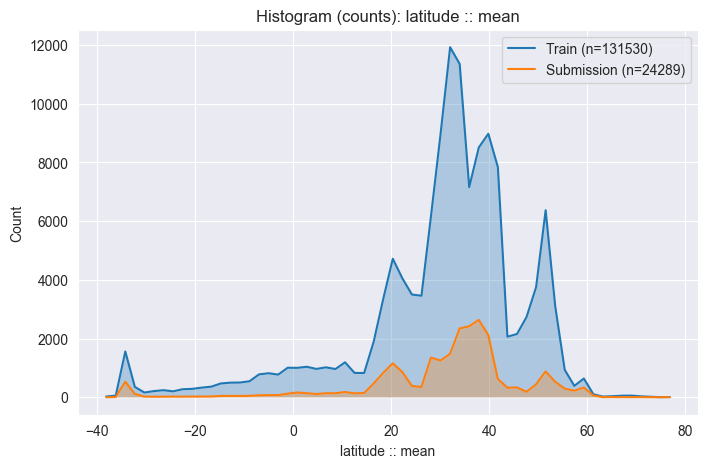

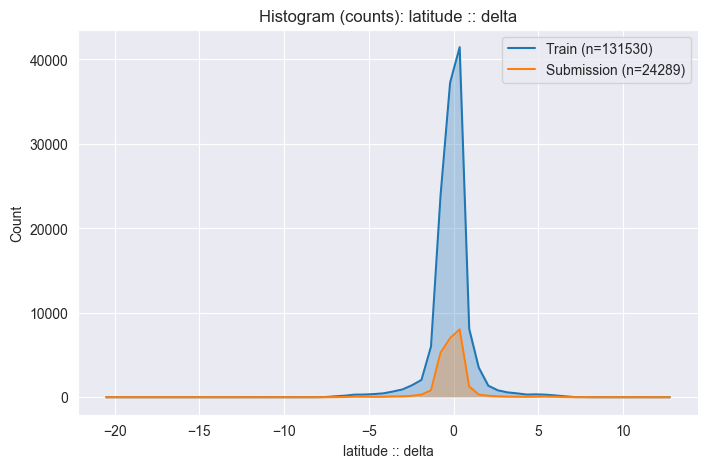

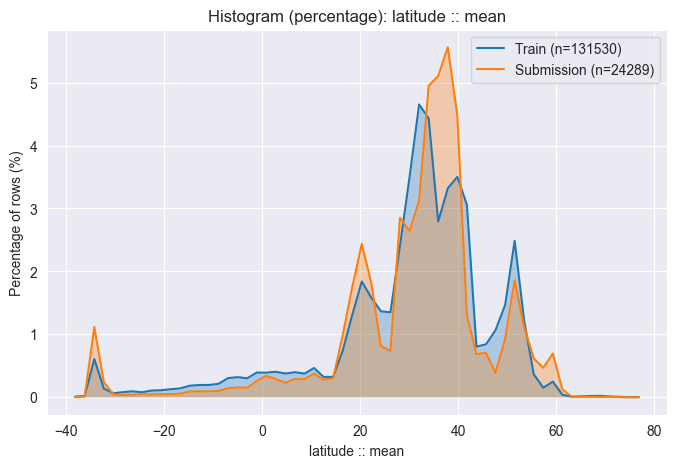

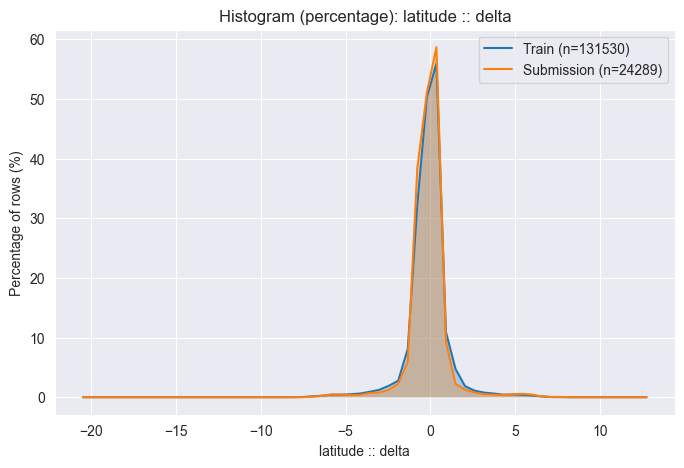

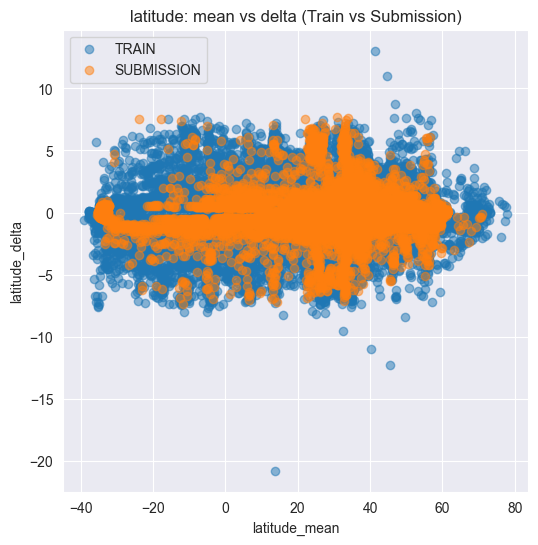


=== latitude :: summaries ===
Train latitude_mean: mean=30.205, std=17.373, n=131530
Train latitude_delta: mean=-0.074, std=1.192, n=131530
Sub   latitude_mean: mean=30.844, std=17.128, n=24289
Sub   latitude_delta: mean=-0.058, std=1.120, n=24289

##### LONGITUDE #####


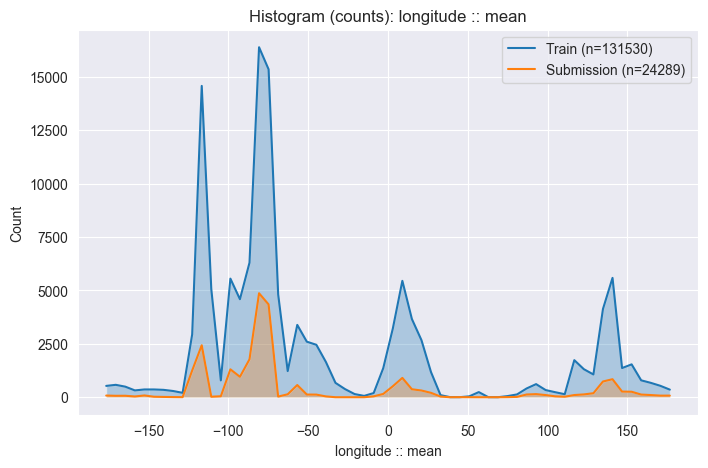

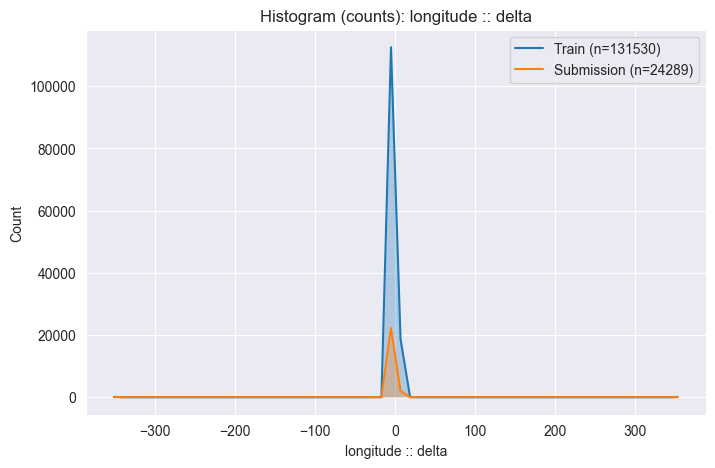

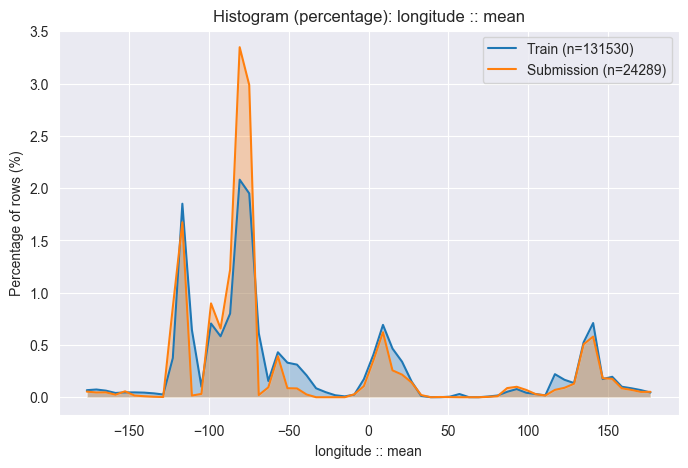

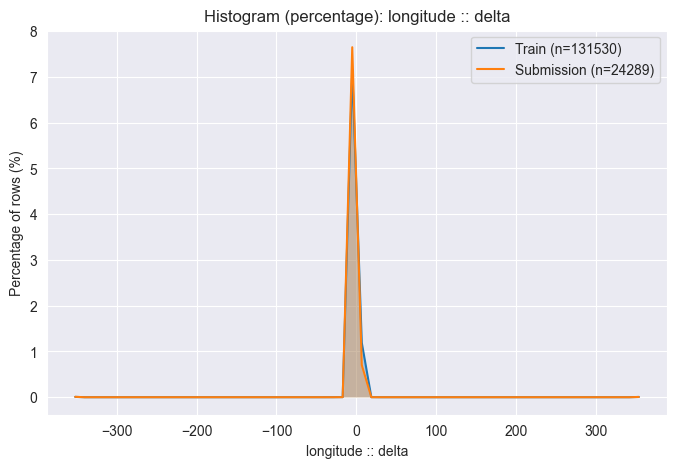

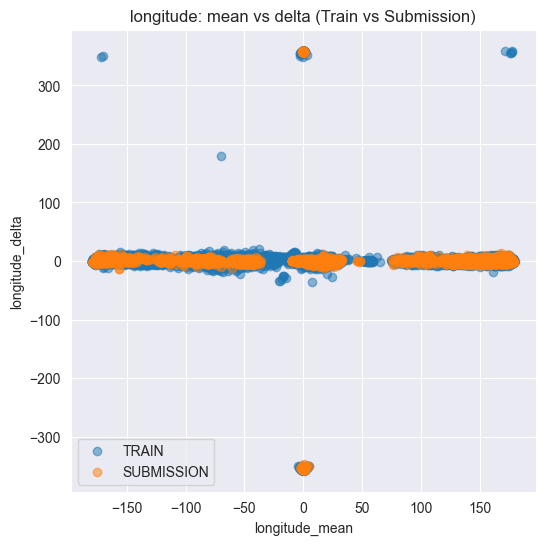


=== longitude :: summaries ===
Train longitude_mean: mean=-39.104, std=86.712, n=131530
Train longitude_delta: mean=-0.069, std=14.074, n=131530
Sub   longitude_mean: mean=-48.310, std=81.985, n=24289
Sub   longitude_delta: mean=-0.155, std=14.659, n=24289

##### ALTITUDE #####


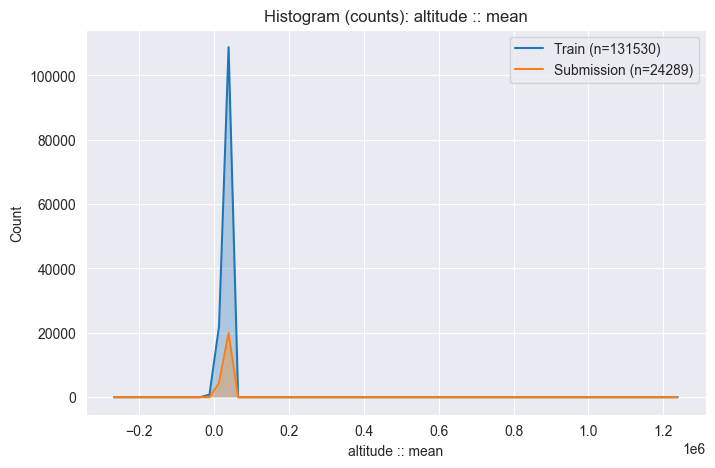

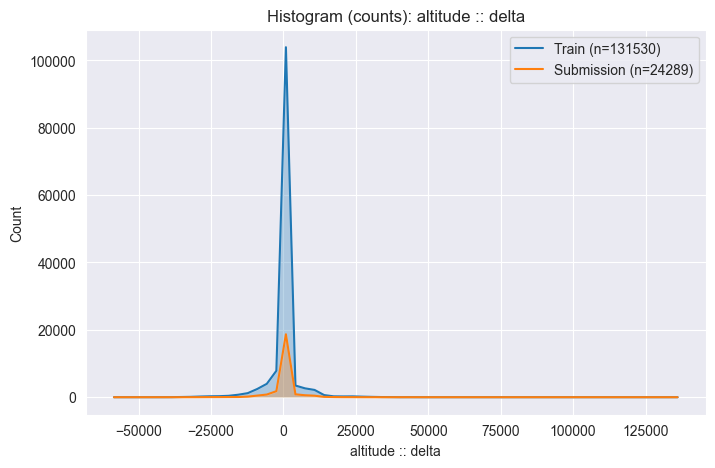

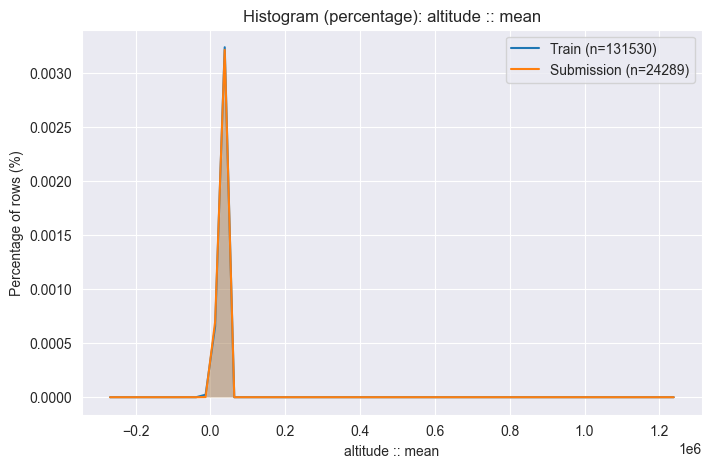

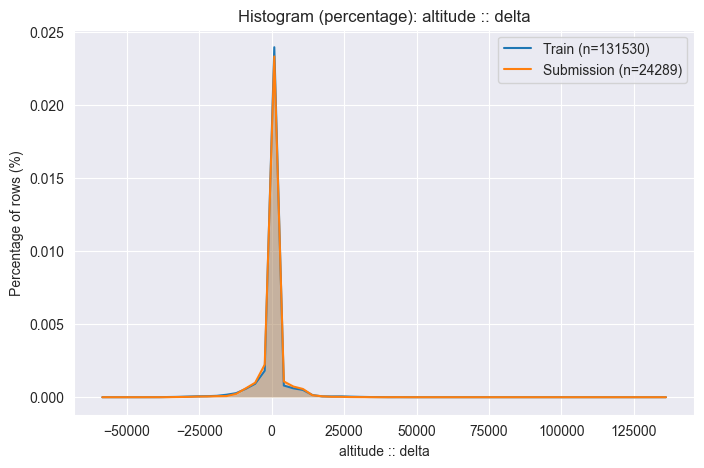

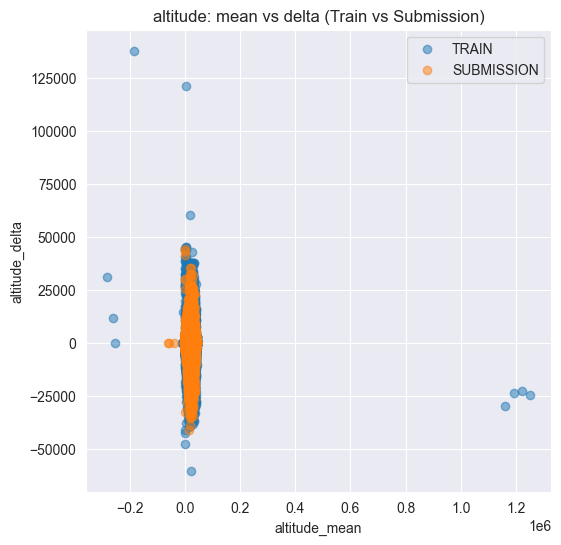


=== altitude :: summaries ===
Train altitude_mean: mean=32030.018, std=12657.929, n=131530
Train altitude_delta: mean=-157.094, std=4674.270, n=131530
Sub   altitude_mean: mean=31721.068, std=10390.849, n=24289
Sub   altitude_delta: mean=-59.292, std=4037.362, n=24289

##### FUEL_KG #####


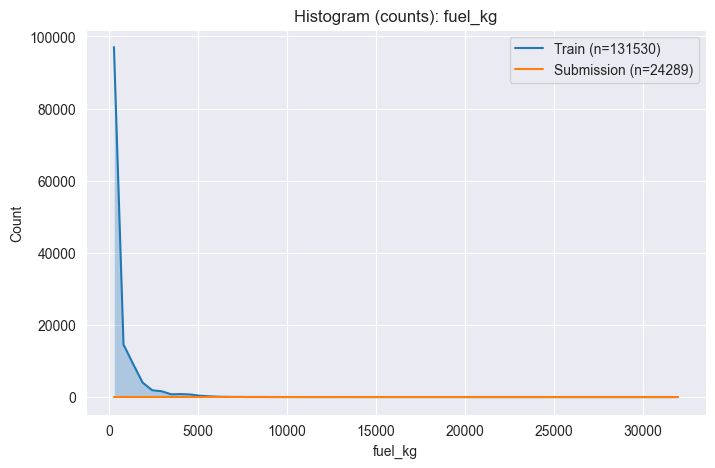

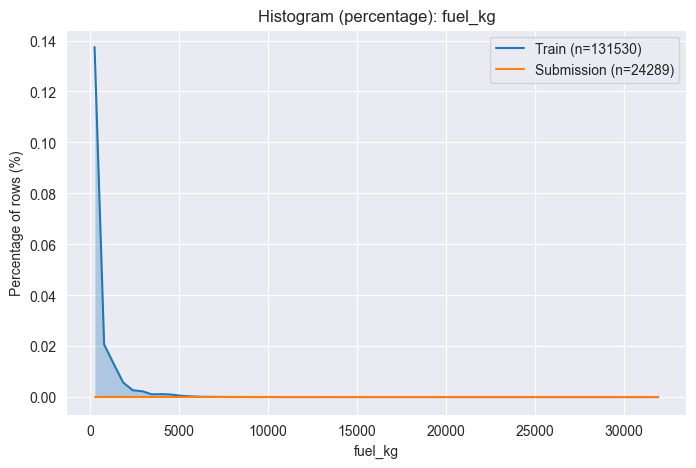


=== fuel_kg :: summaries ===
Train fuel_kg: mean=557.705, std=883.558, n=131530
Sub   fuel_kg: mean=nan, std=nan, n=0

##### DURATION_S #####


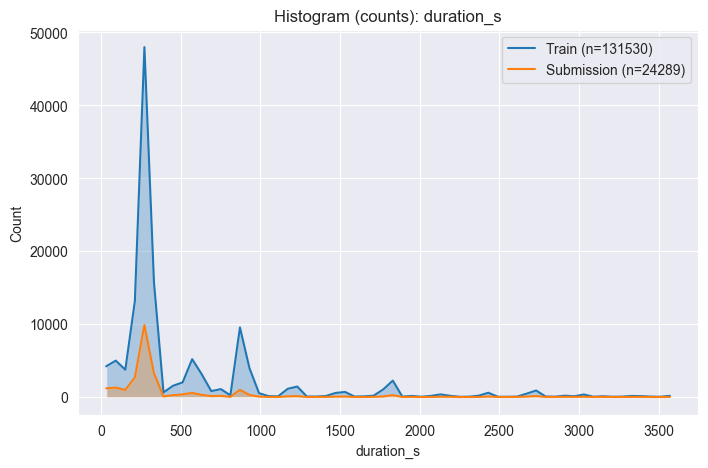

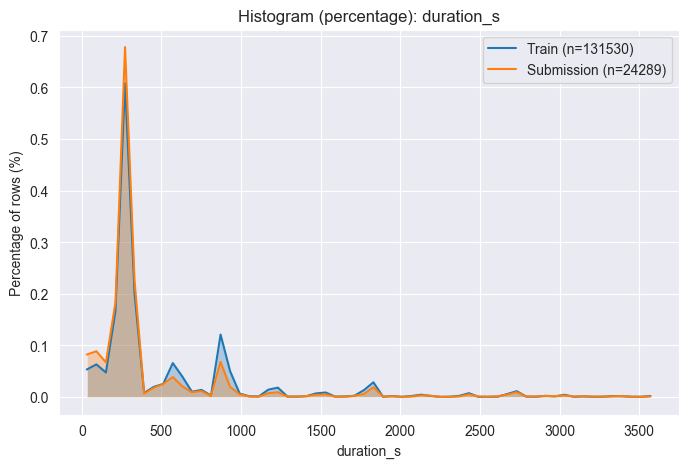


=== duration_s :: summaries ===
Train duration_s: mean=531.938, std=559.682, n=131530
Sub   duration_s: mean=443.234, std=520.785, n=24289


In [35]:
# 1) Compare latitude/longitude/altitude (mean+delta pairs)
compare_many(df_train_inter, df_sub_inter, ["latitude","longitude","altitude"], mean_delta=True, bins=60, abs_delta=False)

# 2) Compare single raw columns like fuel_kg and duration_s
compare_many(df_train_inter, df_sub_inter, ["fuel_kg", "duration_s"], mean_delta=False, bins=60)


##### GROUNDSPEED #####


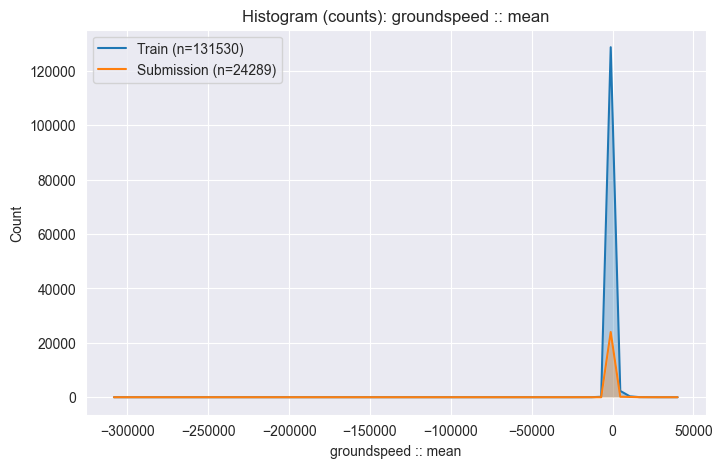

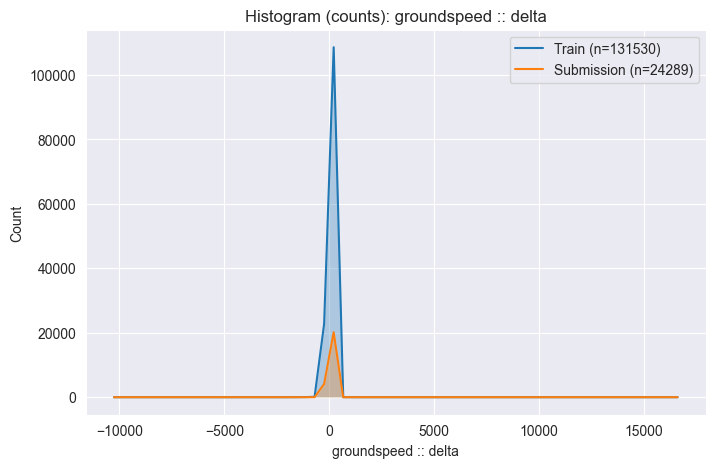

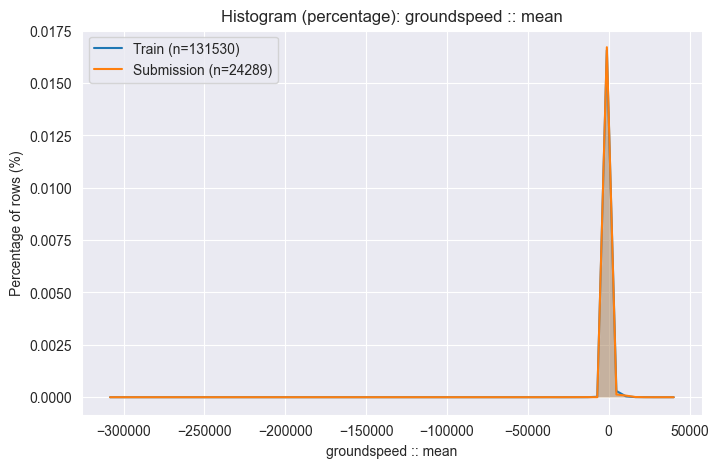

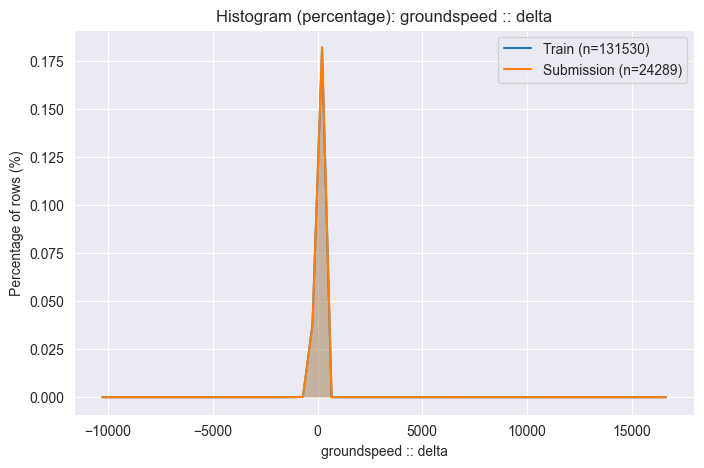

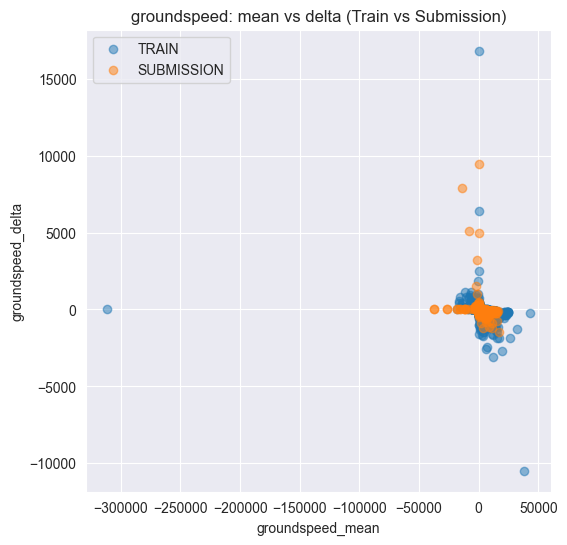


=== groundspeed :: summaries ===
Train groundspeed_mean: mean=503.270, std=1218.432, n=131530
Train groundspeed_delta: mean=-4.956, std=81.814, n=131530
Sub   groundspeed_mean: mean=502.304, std=984.659, n=24289
Sub   groundspeed_delta: mean=-1.488, std=104.861, n=24289

##### TRACK #####


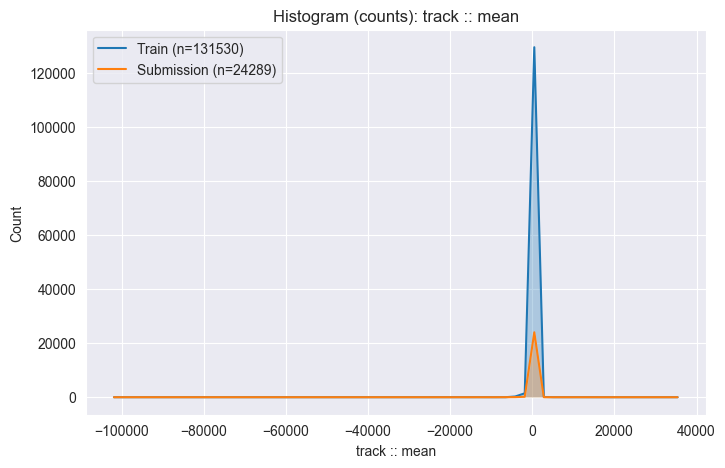

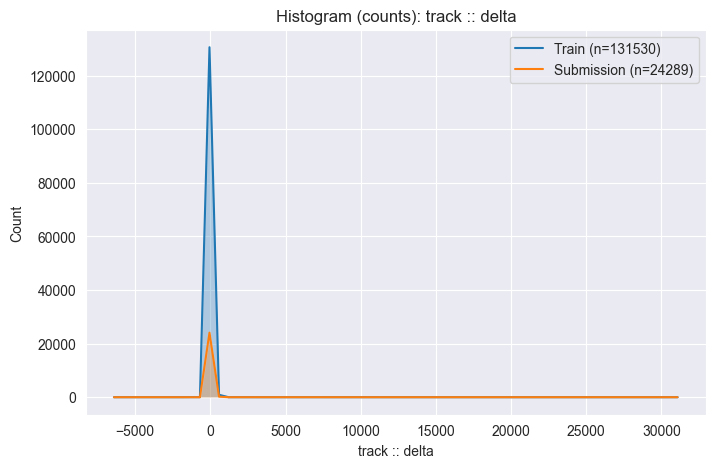

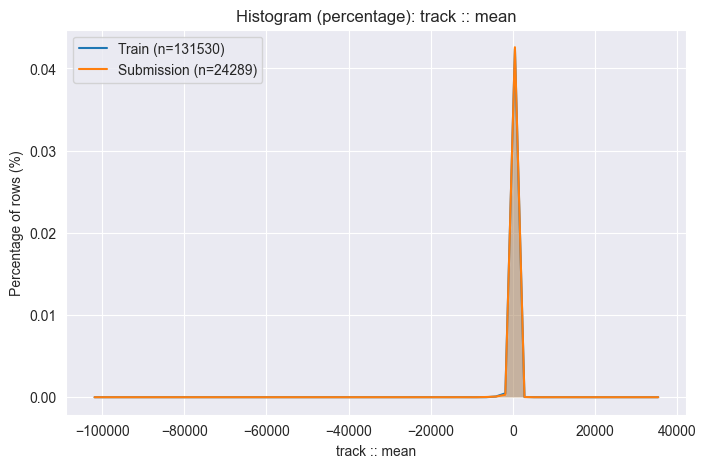

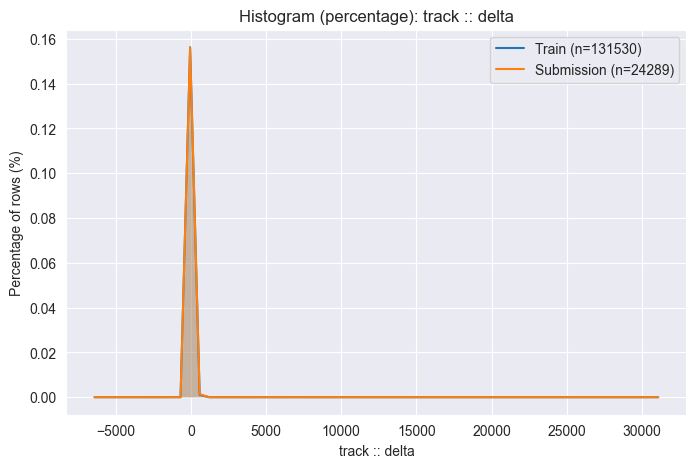

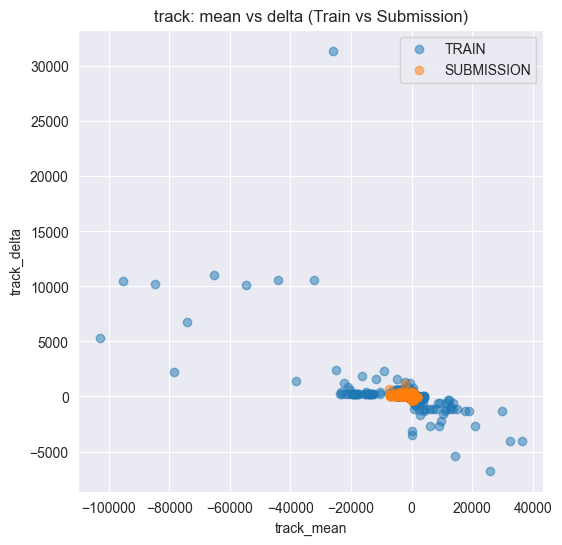


=== track :: summaries ===
Train track_mean: mean=141.964, std=794.119, n=131530
Train track_delta: mean=1.871, std=129.243, n=131530
Sub   track_mean: mean=140.035, std=319.244, n=24289
Sub   track_delta: mean=1.471, std=45.407, n=24289

##### VERTICAL_RATE #####


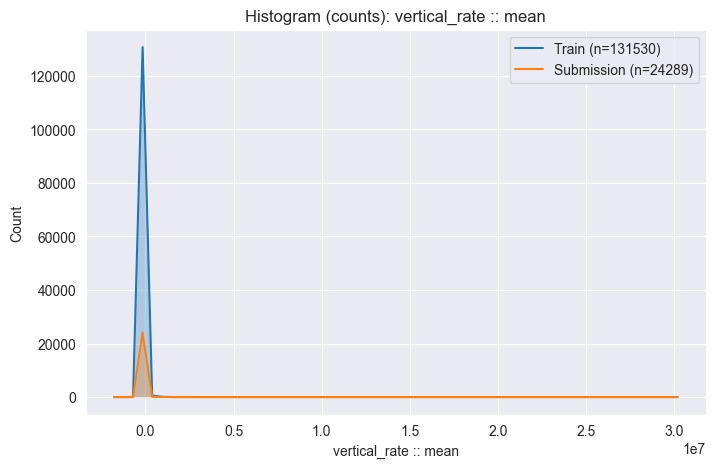

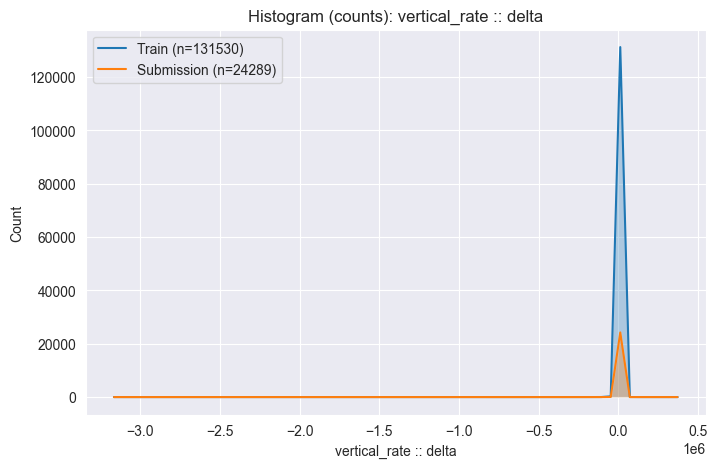

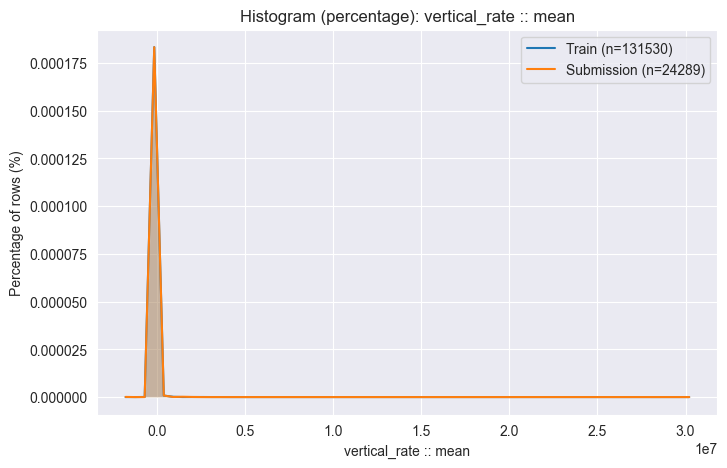

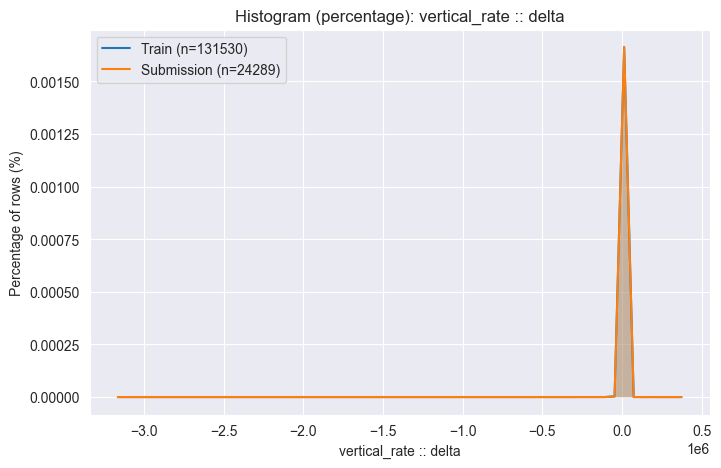

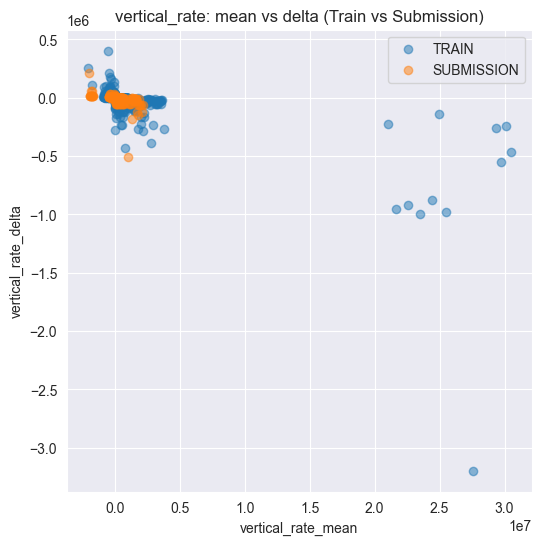


=== vertical_rate :: summaries ===
Train vertical_rate_mean: mean=4558.049, std=260187.614, n=131530
Train vertical_rate_delta: mean=-213.896, std=11578.932, n=131530
Sub   vertical_rate_mean: mean=2361.474, std=78492.773, n=24289
Sub   vertical_rate_delta: mean=-207.501, std=4579.214, n=24289


In [34]:
# 1) Compare latitude/longitude/altitude (mean+delta pairs)
compare_many(df_train_inter, df_sub_inter, ["groundspeed","track","vertical_rate"], mean_delta=True, bins=60, abs_delta=False)


In [ ]:
TRAIN_V2 = pd.read_parquet(os.path.join(DATA_ORIGIN, "processed", "training", "interpolated_train_v2.parquet"))

compare_many(df_train_inter, df_sub_inter, ["groundspeed","track","vertical_rate"], mean_delta=True, bins=60, abs_delta=False)
